In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture



In [2]:
df = pd.read_csv('Gia SMP va SMPcap 2021(Giá thị trường SMP).csv', encoding="latin-1", delimiter=';')
df.head()

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [3]:
data = df[['6']]
data

,6
0,964.4
1,1019.7
2,988.4
3,1002.0
4,1061.5
...,...
360,1002.0
361,1002.0
362,1061.5
363,1022.6


In [4]:
from yellowbrick.cluster import KElbowVisualizer
Elbow_M = KElbowVisualizer(KMeans(random_state=23, n_init=10), k=(4,12))
Elbow_M.fit(data)
Elbow_M.show()

NameError: name 'KMeans' is not defined

In [ ]:
BGM = BayesianGaussianMixture(n_components=8, random_state=27)

preds_bgm = BGM.fit_predict(data)

In [ ]:
pp_1=BGM.predict_proba(data)# Calcualting the probabilities of each prediction
df_new1=pd.DataFrame(data) 
df_new1[[f'predict_proba_{i}' for i in range(8)]]=pp_1 # creating new dataframe columns of probabilites 
df_new1['preds']=preds_bgm
df_new1['predict_proba']=np.max(pp_1,axis=1)
df_new1['predict']=np.argmax(pp_1,axis=1)
    
train_index=np.array([])
for n in range(8):
    n_inx=df_new1[(df_new1.preds==n) & (df_new1.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [ ]:
from sklearn.model_selection import StratifiedKFold
X_new1=df_new1.loc[train_index]
y1=df_new1.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':8} 

model_list1=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new1,y1)):   

    tr_dataset = lgb.Dataset(X_new1.iloc[train_idx],y1.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new1.iloc[valid_idx],y1.iloc[valid_idx])
    
    model1 = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=400, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list1.append(model1) 

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=11.
  warnings.warn(


[200]	valid_0's multi_logloss: 7.57605e-06
[400]	valid_0's multi_logloss: 7.57605e-06
[200]	valid_0's multi_logloss: 7.61599e-06
[400]	valid_0's multi_logloss: 7.61599e-06
[200]	valid_0's multi_logloss: 7.45199e-06
[400]	valid_0's multi_logloss: 7.45199e-06
[200]	valid_0's multi_logloss: 7.49551e-06
[400]	valid_0's multi_logloss: 7.49551e-06
[200]	valid_0's multi_logloss: 7.45187e-06
[400]	valid_0's multi_logloss: 7.45187e-06
[200]	valid_0's multi_logloss: 7.51249e-06
[400]	valid_0's multi_logloss: 7.51249e-06
[200]	valid_0's multi_logloss: 7.61131e-06
[400]	valid_0's multi_logloss: 7.61131e-06
[200]	valid_0's multi_logloss: 6.92801e-06
[400]	valid_0's multi_logloss: 6.92801e-06
[200]	valid_0's multi_logloss: 6.48735e-06
[400]	valid_0's multi_logloss: 6.48735e-06
[200]	valid_0's multi_logloss: 6.45003e-06
[400]	valid_0's multi_logloss: 6.45003e-06
[200]	valid_0's multi_logloss: 6.41061e-06
[400]	valid_0's multi_logloss: 6.41061e-06


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6260\3672433496.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=np.argmax(lgb_preds1,axis=1), palette = "Set1")


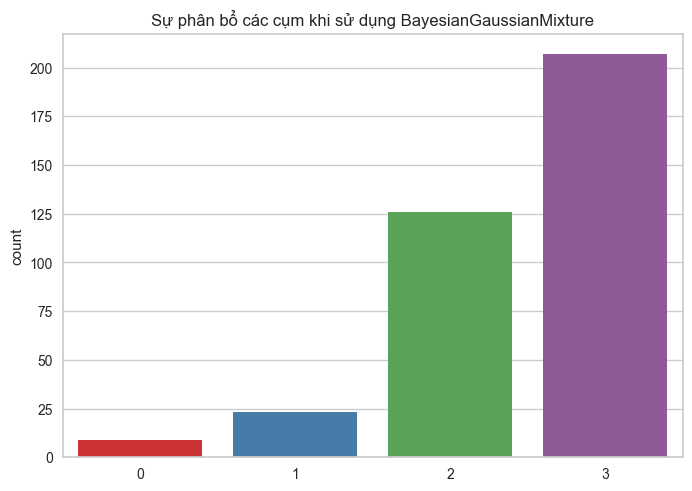

In [ ]:
lgb_preds1=0
for model1 in model_list1:
    lgb_preds1+=model1.predict(df_new1)
    
pl = sns.countplot(x=np.argmax(lgb_preds1,axis=1), palette = "Set1")
pl.set_title("Sự phân bổ các cụm khi sử dụng BayesianGaussianMixture")
plt.show()

In [ ]:
GM = GaussianMixture(n_components=8)

preds_gm = GM.fit_predict(data)

In [ ]:
pp_2=GM.predict_proba(data)# Calcualting the probabilities of each prediction
df_new2=pd.DataFrame(data) 
df_new2[[f'predict_proba_{i}' for i in range(8)]]=pp_2 # creating new dataframe columns of probabilites 
df_new2['preds']=preds_gm
df_new2['predict_proba']=np.max(pp_2,axis=1)
df_new2['predict']=np.argmax(pp_2,axis=1)
    
train_index=np.array([])
for n in range(8):
    n_inx=df_new2[(df_new2.preds==n) & (df_new2.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [ ]:
X_new2=df_new2.loc[train_index]
y2=df_new2.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':8} 

model_list2=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new2,y2)):   

    tr_dataset = lgb.Dataset(X_new2.iloc[train_idx],y2.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new2.iloc[valid_idx],y2.iloc[valid_idx])
    
    model2 = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list2.append(model2) 

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=11.
  warnings.warn(


[200]	valid_0's multi_logloss: 5.06953e-05
[400]	valid_0's multi_logloss: 5.01963e-05
[600]	valid_0's multi_logloss: 5.00045e-05
[800]	valid_0's multi_logloss: 4.99458e-05
[1000]	valid_0's multi_logloss: 4.99071e-05
[1200]	valid_0's multi_logloss: 4.98737e-05
[1400]	valid_0's multi_logloss: 4.98448e-05
[1600]	valid_0's multi_logloss: 4.98195e-05
[1800]	valid_0's multi_logloss: 4.97975e-05
[2000]	valid_0's multi_logloss: 4.97781e-05
[2200]	valid_0's multi_logloss: 4.97608e-05
[2400]	valid_0's multi_logloss: 4.97452e-05
[2600]	valid_0's multi_logloss: 4.97312e-05
[2800]	valid_0's multi_logloss: 4.97185e-05
[3000]	valid_0's multi_logloss: 4.97069e-05
[3200]	valid_0's multi_logloss: 4.96962e-05
[3400]	valid_0's multi_logloss: 4.96864e-05
[3600]	valid_0's multi_logloss: 4.96773e-05
[3800]	valid_0's multi_logloss: 4.96689e-05
[4000]	valid_0's multi_logloss: 4.96604e-05
[4200]	valid_0's multi_logloss: 4.96521e-05
[4400]	valid_0's multi_logloss: 4.96443e-05
[4600]	valid_0's multi_logloss: 4.96

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6260\340265781.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=np.argmax(lgb_preds2,axis=1), palette = "Set1")


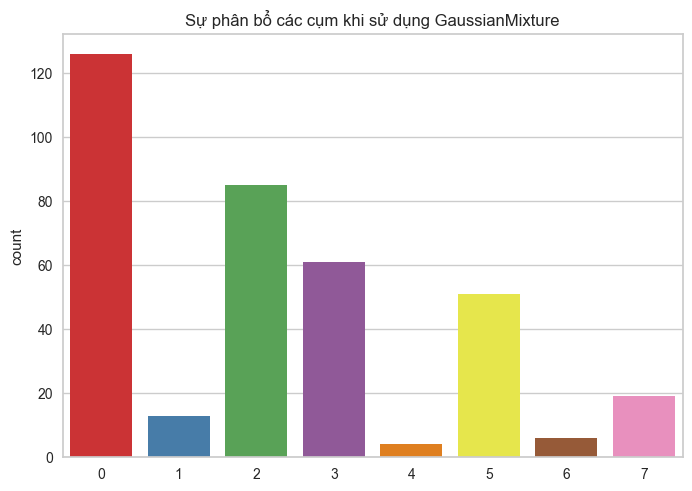

In [ ]:
lgb_preds2=0
for model2 in model_list2:
    lgb_preds2+=model2.predict(df_new2)
    
pl = sns.countplot(x=np.argmax(lgb_preds2,axis=1), palette = "Set1")
pl.set_title("Sự phân bổ các cụm khi sử dụng GaussianMixture")
plt.show()